In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) #set default figure size

In [2]:
cboe_quotes = np.loadtxt('CBOEQuotes.txt')
cboe_quotes

array([[6.500e+02, 2.323e+02, 2.343e+02],
       [6.750e+02, 2.075e+02, 2.095e+02],
       [7.000e+02, 1.829e+02, 1.849e+02],
       [7.250e+02, 1.585e+02, 1.605e+02],
       [7.500e+02, 1.344e+02, 1.364e+02],
       [7.600e+02, 1.249e+02, 1.269e+02],
       [7.650e+02, 1.201e+02, 1.221e+02],
       [7.750e+02, 1.108e+02, 1.128e+02],
       [8.000e+02, 8.790e+01, 8.990e+01],
       [8.100e+02, 7.900e+01, 8.100e+01],
       [8.250e+02, 6.620e+01, 6.820e+01],
       [8.500e+02, 4.650e+01, 4.850e+01],
       [8.700e+02, 3.270e+01, 3.470e+01],
       [8.750e+02, 3.000e+01, 3.110e+01],
       [8.800e+02, 2.700e+01, 2.870e+01],
       [8.900e+02, 2.150e+01, 2.330e+01],
       [9.000e+02, 1.700e+01, 1.840e+01],
       [9.100e+02, 1.280e+01, 1.440e+01],
       [9.200e+02, 9.800e+00, 1.080e+01],
       [9.250e+02, 8.500e+00, 9.400e+00],
       [9.300e+02, 7.200e+00, 8.200e+00],
       [9.400e+02, 5.100e+00, 6.100e+00],
       [9.500e+02, 3.700e+00, 4.400e+00],
       [9.750e+02, 1.600e+00, 2.00

In [3]:
T = 30/365 # 30 days to maturity
S0 = 884.25 # current stock price
q = 0.0176 # dividend yield
r = 0.0125 # risk-free rate
K = cboe_quotes[:,0] # strike prices
bid = cboe_quotes[:,1] # bid prices
ask = cboe_quotes[:,2] # ask prices
mean = (bid + ask)/2 # mean of bid and ask prices

## Bisection Method

In [4]:
def Black_Scholes_Call(S, K, r, q, T, sigma):
    """Black-Scholes call option price.
    
    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: call option price
    """
    if sigma == 0:
        return max(S * np.exp(- q * T) - K * np.exp(- r * T), 0)
    else:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(- q * T) * norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)

In [21]:
def implied_volatility_bisection(S, K, r, q, T, C, tol=1e-6, max_iter=1000):
    if C < S * np.exp(- q * T) - K * np.exp(- r * T):
        print("Option price violates the arbitrage bound.")
        return np.nan
    
    lower = 0
    flower = Black_Scholes_Call(S, K, r, q, T, lower) - C
    upper = 1
    fupper = Black_Scholes_Call(S, K, r, q, T, upper) - C
    while fupper < 0:
        upper *= 2
        fupper = Black_Scholes_Call(S, K, r, q, T, upper) - C
    
    guess = (lower + upper) / 2
    fguess = Black_Scholes_Call(S, K, r, q, T, guess) - C
    
    while upper - lower > tol and max_iter > 0:
        if fguess * fupper < 0:
            lower = guess
            flower = fguess
            guess = (lower + upper) / 2
            fguess = Black_Scholes_Call(S, K, r, q, T, guess) - C
        else:
            upper = guess
            fupper = fguess
            guess = (lower + upper) / 2
            fguess = Black_Scholes_Call(S, K, r, q, T, guess) - C
        max_iter -= 1
    return guess

In [22]:
implied_volatility_bisection(S0, K[0], r, q, T, ask[0], tol=1e-6, max_iter=1000)

0.5046257972717285

## Newton Method

In [15]:
def vega(S, K, r, q, T, sigma):
    """Vega of a call option.
    
    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: vega
    """
    if sigma == 0:
        return 0
    else:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        return S * np.exp(- q * T) * norm.pdf(d1) * np.sqrt(T)

In [16]:
def implied_volatility(S, K, r, q, T, C, sigma_guess=0.5, tol=1e-6, max_iter=1000):
    """Implied volatility.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        C (float): call option price
        sigma_guess (float): initial guess of volatility
        tol (float): tolerance
        max_iter (int): maximum number of iterations

    Returns:
        float: implied volatility
    """
    sigma = sigma_guess
    for i in range(max_iter):
        diff = Black_Scholes_Call(S, K, r, q, T, sigma) - C
        if abs(diff) < tol:
            break
        sigma -= diff / vega(S, K, r, q, T, sigma)
    return sigma

In [23]:
iv_bid = np.array([implied_volatility_bisection(S0, K[i], r, q, T, bid[i]) for i in range(len(K))])
iv_ask = np.array([implied_volatility_bisection(S0, K[i], r, q, T, ask[i]) for i in range(len(K))])
iv_mean = np.array([implied_volatility_bisection(S0, K[i], r, q, T, mean[i]) for i in range(len(K))])

Option price violates the arbitrage bound.
Option price violates the arbitrage bound.
Option price violates the arbitrage bound.
Option price violates the arbitrage bound.
Option price violates the arbitrage bound.
Option price violates the arbitrage bound.


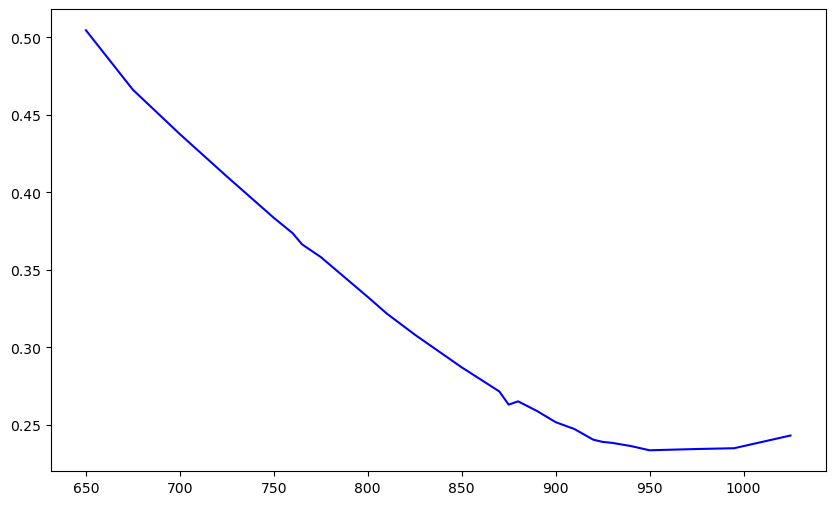

In [24]:
fig, ax = plt.subplots()
ax.plot(K, iv_ask, 'b', label='Implied Volatility')
plt.show()